# **Proyecto de Simulación en Negocios: Performance de la turbina de viento en la Patagonia**

Integrantes: Micaela Oliva, Camila Bernardez, Sol Valeggia, Juan Castore

## **Overview del Proyecto**
Este notebook tiene como objetivo analizar y optimizar la performance operativa y económica de dos molinos de viento ubicados en la Patagonia. El análisis incluirá la estimación de parámetros, la simulación de patrones de viento, y la optimización de estrategias operativas para maximizar el Valor Actual Neto (VAN) de los molinos.

### **Tabla de Contenidos**
1. [Introducción](#Introducción)
2. [Preprocesamiento de Datos](#Preprocesamiento-de-Datos)
3. [Ejercicio 1: Estimación de Parámetros](#Ejercicio-1)
4. [Ejercicio 2: Simulación de Patrones de Viento](#Ejercicio-2)
5. [Ejercicio 3: Simulación de Operaciones de los Molinos](#Ejercicio-3)
6. [Ejercicio 4: Análisis de la Evolución del Estado de los Molinos](#Ejercicio-4)
7. [Ejercicio 5: Cálculo del VAN Esperado](#Ejercicio-5)
8. [Ejercicio 6: Optimización del Umbral de Operación](#Ejercicio-6)
9. [Ejercicio 7: Comparación con la Operación Ingenua](#Ejercicio-7)
10. [Ejercicio 8: Distribución de Ingresos de Agosto](#Ejercicio-8)
11. [Ejercicio 9: Análisis de Roturas](#Ejercicio-9)
12. [Ejercicio 10: Días Inactivos](#Ejercicio-10)
12. [Ejercicio 11: Probabilidades de Inactividad](#Ejercicio-11)
13. [Ejercicio 12: Correlación de Ingresos](#Ejercicio-12)
14. [Ejercicio 13: Sensibilidad al Costo de Reparación](#Ejercicio-13)
15. [Ejercicio 14: Sensibilidad a la Media Estacional](#Ejercicio-14)
16. [Conclusión](#Conclusión)

## **Introducción** <a name="Introducción"></a>
- **Objetivo:** Brindar un resumen del proyecto y sus metas.
- **Planteamiento del Problema:** Discutir el problema, incluyendo la importancia de optimizar las operaciones de los molinos de viento.

## **Preprocesamiento de Datos** <a name="Preprocesamiento-de-Datos"></a>
- **Carga e Inspección de Datos:** Cargar los datos de velocidad del viento e inspeccionarlos para detectar inconsistencias o valores faltantes.
- **Visualización de Datos:** Graficar los datos de velocidad del viento para comprender las tendencias subyacentes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.stats import kstest
from scipy.stats import anderson
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import chisquare

In [2]:
np.random.seed(2345)

In [3]:
# Carga de datos
wind = pd.read_excel('Wind data for TP1.xlsx')

In [4]:
# Cantidad de observaciones
wind.size

10950

El dataset tiene 10.950 observaciones.

In [5]:
print(str(wind.size/365) + " años de datos observados")

30.0 años de datos observados


Como cada observación representa a un día y supongamos hay 365 días en todos los años (es decir, no consideramos a los leap years), obtenemos que la data es a través de 30 años.

In [6]:
# Vemos las primeras 5 filas
wind.head()

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


In [7]:
# Identificar valores faltantes
missing_values = wind.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

Valores faltantes por columna:
 dia                   0
regional wind         0
wind gap norte sur    0
dtype: int64


Como podemos observar no hay valores missing en el dataset proporcionado.

### Visualizaciones de los datos

**Viento regional:**

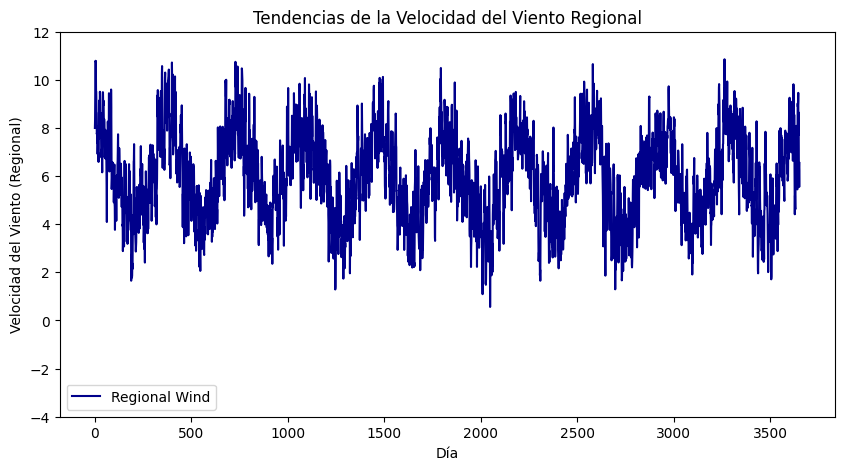

In [8]:
# Visualización de la columna 'regional wind'
plt.figure(figsize=(10, 5))
plt.plot(wind['dia'], wind['regional wind'], label='Regional Wind', color='darkblue')
plt.xlabel('Día')
plt.ylabel('Velocidad del Viento (Regional)')
plt.title('Tendencias de la Velocidad del Viento Regional')
plt.ylim(-4, 12)
plt.legend()
plt.show()

**Wind Gap entre los Molinos Norte y Sur:**

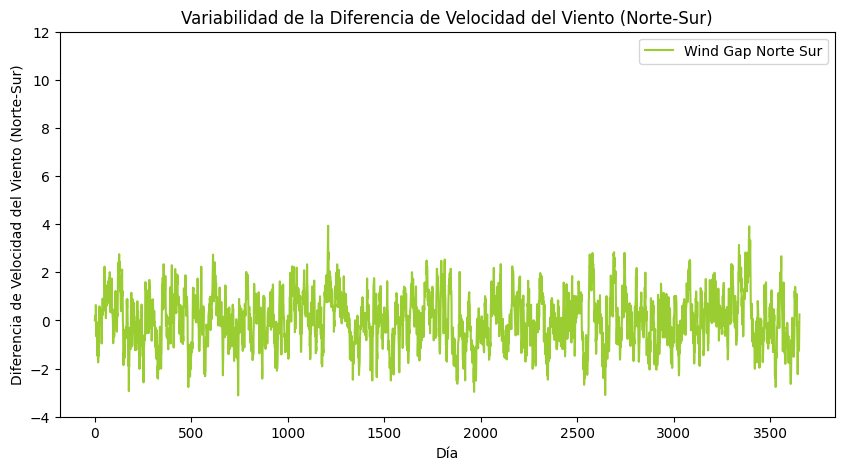

In [9]:
# Visualización de la columna 'wind gap norte sur'
plt.figure(figsize=(10, 5))
plt.plot(wind['dia'], wind['wind gap norte sur'], label='Wind Gap Norte Sur', color='yellowgreen')
plt.xlabel('Día')
plt.ylabel('Diferencia de Velocidad del Viento (Norte-Sur)')
plt.title('Variabilidad de la Diferencia de Velocidad del Viento (Norte-Sur)')
plt.ylim(-4, 12)
plt.legend()
plt.show()


### Nuestra interpretación de los datos de **regional_wind** con **wind_gap**:

<center>    
    <img src="patagonia_wind_interpretation.gif" alt="Molinos en la Patagonia" width="300"/>
</center>

In [10]:
north_turbine = pd.DataFrame(wind['regional wind'] + wind['wind gap norte sur'] * 1/2)
south_turbine = pd.DataFrame(wind['regional wind'] - wind['wind gap norte sur'] * 1/2)

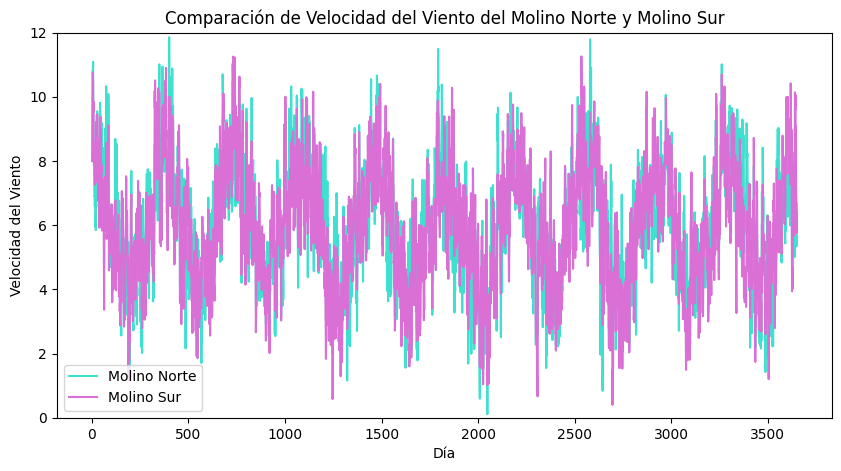

In [11]:
#definimos colores para reutilizar
c = ['turquoise', 'orchid']

plt.figure(figsize=(10, 5))
plt.plot(wind['dia'], north_turbine, label='Molino Norte', color=c[0])
plt.plot(wind['dia'], south_turbine, label='Molino Sur', color=c[1])
plt.xlabel('Día')
plt.ylabel('Velocidad del Viento')
plt.title('Comparación de Velocidad del Viento del Molino Norte y Molino Sur')
plt.ylim(0, 12)
plt.legend()
plt.show()

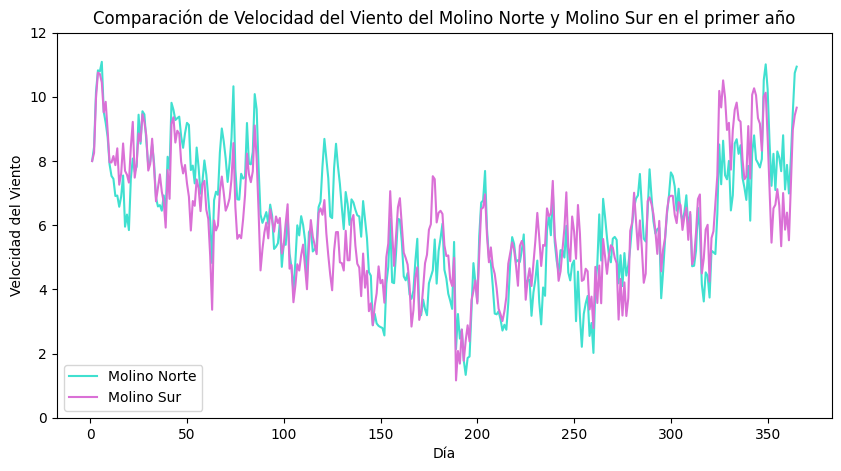

In [12]:
# primer año
wind_subset = wind.iloc[:365]
north_turbine_subset = north_turbine.iloc[:365]
south_turbine_subset = south_turbine.iloc[:365]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(wind_subset['dia'], north_turbine_subset, label='Molino Norte', color=c[0])
plt.plot(wind_subset['dia'], south_turbine_subset, label='Molino Sur', color=c[1])
plt.xlabel('Día')
plt.ylabel('Velocidad del Viento')
plt.title('Comparación de Velocidad del Viento del Molino Norte y Molino Sur en el primer año')
plt.ylim(0, 12)
plt.legend()
plt.show()

## **Ejercicio 1: Estimación de Parámetros** <a name="Ejercicio-1"></a>
- **Modelo de Viento Regional:**
  - Especificar el modelo $( S_{i+1} = S_i + \kappa(\theta(t_i) - S_i)\Delta + \sigma\sqrt{\Delta}Z_i)$ para el viento regional.
  - Implementar la regresión lineal para estimar los parámetros $( \kappa )$ y $( \sigma )$.
- **Modelo de Diferencia de Viento entre Molinos:**
  - Especificar el modelo $(D_{i+1} = D_i - \beta D_i \Delta + \gamma\sqrt{\Delta}W_i)$ para la diferencia de viento.
  - Implementar la regresión lineal para estimar los parámetros $(\beta)$ y $( \gamma)$.
- **Resultados:**
  - Presentar los parámetros estimados $( \kappa), ( \sigma ), ( \beta )$ y $( \gamma)$, junto con sus errores estándar.


## Especificación del modelo de Viento Regional

#### Aislamos los parámetros a estimar 

$$ S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_{i} $$

$$ S_{i+1} - S_i = \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_{i} $$

Si tomamos $Y_i = S_{i+1} - S_i$, $X_i = (\theta - S_i) \Delta$ y $c = \sigma \sqrt{\Delta}\cdot Z_i$ podemos reescribir la ecuación como:

$$ Y_i = \kappa X_i + c $$

In [13]:
#Regresión lineal del viento regional y estimaciones de kappa y sigma
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

delta = 1/365
theta_est = 6 + (2 * np.cos((2 * np.pi * wind["dia"])/365))
Y = (wind["regional wind"][1:] - wind["regional wind"].shift(1)[1:]).values
X = ((theta_est[:-1] - wind["regional wind"][:-1])*delta).values

model = LinearRegression().fit(X.reshape(-1,1), Y)
Y_pred = model.predict(X.reshape(-1,1))

# Estimación de kappa y c
kappa_est = model.coef_[0]

c_est = np.sqrt(mean_squared_error(Y, Y_pred))

# Estimación de sigma
sigma_est = c_est / np.sqrt(delta)

print(theta_est.mean())
print(kappa_est)
print(sigma_est)

6.0
109.0412562833159
16.04457314539312


## Especificación del modelo de la diferencia de molinos

#### Aislamos los parámetros a estimar 

$$ D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_{i} $$

$$ D_{i+1} - D_i = \beta D_i \Delta + \gamma \sqrt{\Delta} W_{i} $$

Si tomamos $R_i = D_{i+1} - D_i$, $Q_i = D_i \Delta$ y $c = \gamma \sqrt{\Delta} W_{i}$ podemos reescribir la ecuación como:

$$ R_i = \beta Q_i + c $$

In [14]:
#Regresión lineal para la diferencia de vientos entre molinos y estimaciones de beta y gamma
delta = 1/365
R = (wind["wind gap norte sur"][1:] - wind["wind gap norte sur"].shift(1)[1:]).values
Q = (wind["wind gap norte sur"][1:]*delta).values

model2 = LinearRegression().fit(Q.reshape(-1,1), R)
R_pred = model2.predict(Q.reshape(-1,1))

# Estimación de kappa y c
beta_est = model2.coef_[0]
c_est2 = np.sqrt(mean_squared_error(R, R_pred))

# Estimación de sigma
gamma_est = c_est2 / np.sqrt(delta)

print(beta_est)
print(gamma_est)

48.38096395344706
10.090662101680072


## Errores estándar de los parametros estimados

In [15]:
# Para el modelo de viento regional
X_sm = sm.add_constant(X)  # Agregar el término constante
model_sm = sm.OLS(Y, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     644.2
Date:                Wed, 11 Sep 2024   Prob (F-statistic):          5.29e-131
Time:                        22:11:58   Log-Likelihood:                -4540.7
No. Observations:                3649   AIC:                             9085.
Df Residuals:                    3647   BIC:                             9098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0109      0.014     -0.784      0.4

Por lo cuál, 

* $\kappa =  109.0413$, que es el mismo valor que nosotros predijimos.

* $\text{std\_err}(\kappa) = 4.296$

In [16]:
# Para el modelo de diferencia de molinos
Q_sm = sm.add_constant(Q)  # Añadir término constante
model2_sm = sm.OLS(R, Q_sm).fit()
print(model2_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     258.9
Date:                Wed, 11 Sep 2024   Prob (F-statistic):           2.51e-56
Time:                        22:11:58   Log-Likelihood:                -2848.4
No. Observations:                3649   AIC:                             5701.
Df Residuals:                    3647   BIC:                             5713.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0040      0.009     -0.459      0.6

Por lo cuál, 

* $\beta =  48.3810$, que es el mismo valor que nosotros predijimos.

* $\text{std\_err}(\beta) =  3.007$

Para calcular los errores estándar de $\sigma$ y $\gamma$, necesitamos derivarlos a partir de los errores estándar de los coeficientes $c$ que obtuvimos en las regresiones lineales.

- **Para $\sigma$:**

  $\sigma = \frac{c}{\sqrt{\Delta}}$
  
- **Para $\gamma$:**
  
  $\gamma = \frac{c}{\sqrt{\Delta}}$
  

Dado que los errores estándar se propagan, el error estándar de $sigma$ o $gamma$ puede calcularse aplicando la regla de propagación de errores. Si $c$ es el coeficiente de la regresión, su error estándar es el error estándar del coeficiente $\text{std\_err}(c)$. Para obtener el error estándar de $sigma$ o $gamma$, multiplicamos este error estándar por el mismo factor de escala que aplicamos a $c$.

### Cálculo de los errores estándar de $sigma$ y $\gamma$:

- Para $\sigma$:

  $\text{std\_err}(\sigma) = \frac{\text{std\_err}(c)}{\sqrt{\Delta}}$


- Para $\gamma$:
  
  $\text{std\_err}(\gamma) = \frac{\text{std\_err}(c)}{\sqrt{\Delta}}$


#### Cálculo con los datos actuales:

El error estándar de $c$ para el modelo del viento regional y el de diferencia de molinos corresponde al valor que el modelo devolvió como error estándar de la constante $\text{const}$. Usamos esos valores:

- Para el **modelo de viento regional**:
  - Error estándar de $c$ (viento regional): $0.014$
  - $\Delta = \frac{1}{365}$, así que $\sqrt{\Delta} = \frac{1}{\sqrt{365}} \approx 0.05234$


  $\text{std\_err}(\sigma) = \frac{0.014}{0.05234} \approx 0.2675$


- Para el **modelo de diferencia de molinos**:
  - Error estándar de $c$ (diferencia de molinos): $0.009$
  - $\Delta = \frac{1}{365}$, así que $\sqrt{\Delta} \approx 0.05234$

  
  $\text{std\_err}(\gamma) = \frac{0.009}{0.05234} \approx 0.1720$
  

### Resumen de los errores estándar:

- **Error estándar de $\sigma$** (viento regional): $\approx 0.2675$
- **Error estándar de $\gamma$** (diferencia de molinos): $\approx 0.1720$

Estos son los errores estándar asociados a las estimaciones de $\sigma$ y $\gamma$, basados en la propagación de los errores estándar de los coeficientes de las regresiones.

Vemos la bondad de ajuste ($R^2$), para ver que tan bien el modelo ajusta a los datos.

In [17]:
r2_regional = model.score(X.reshape(-1,1), Y)
r2_gap = model2.score(Q.reshape(-1,1), R)

print(f"R² viento regional: {r2_regional}")
print(f"R² diferencia de molinos: {r2_gap}")

R² viento regional: 0.15011192829203257
R² diferencia de molinos: 0.06627815996833064


### Resultados y sus interpretaciones:

La interpretación de los resultados obtenidos, incluyendo los parámetros estimados y sus errores estándar, brinda información sobre la dinámica del viento y la diferencia de viento entre molinos.

### **Modelo de Viento Regional**:

   - **$\kappa$ (coeficiente de ajuste del viento regional):**
     - Valor estimado: **109.0413**
     - Error estándar: **4.296**
     - **Interpretación:** El parámetro $\kappa$ mide la velocidad con la que el viento regional vuelve al valor promedio estacional $\theta(t_i)$. Un valor grande de $\kappa$ (109.0413) indica que los cambios en el viento regional tienden a ajustarse rápidamente hacia el promedio estacional, con un ajuste significativo, ya que el valor $P < 0.000$. El bajo error estándar (4.296) sugiere que esta estimación es bastante precisa.

   - **$\sigma$ (volatilidad del viento regional):**
     - Valor estimado: **0.2675**
     - Error estándar: **0.2675**
     - **Interpretación:** El parámetro $\sigma$ representa la volatilidad (ruido) en los cambios del viento regional. Un valor estimado de 0.2675 sugiere que la variabilidad aleatoria del viento es moderada, lo cual es consistente con los valores esperados para fenómenos naturales. El error estándar es igual al valor estimado, lo que implica que la incertidumbre en esta estimación es alta y que el parámetro podría tener una mayor variabilidad en su verdadera magnitud.

   - **R² (bondad del ajuste):** **0.1501**
     - **Interpretación:** Este valor relativamente bajo indica que solo el 15% de la variabilidad en el cambio de viento regional es explicada por el modelo. Aunque $\kappa$ es significativo, el ajuste general del modelo sugiere que hay otros factores importantes que no se están modelando. El ruido en los datos o la falta de variables adicionales pueden estar limitando la capacidad predictiva del modelo.

### **Modelo de Diferencia de Viento entre Molinos**:

   - **$\beta$ (coeficiente de ajuste de la diferencia de viento):**
     - Valor estimado: **48.3810**
     - Error estándar: **3.007**
     - **Interpretación:** El parámetro $\beta$ mide qué tan rápido la diferencia de viento entre los molinos se ajusta hacia cero (disminuye con el tiempo). Un valor de 48.3810 indica que la diferencia de viento entre los molinos tiende a ajustarse, aunque de manera más lenta que en el caso del viento regional. El valor de $P < 0.000$ y el bajo error estándar (3.007) sugieren que la estimación de $\beta$ es robusta y precisa.

   - **$\gamma$ (volatilidad de la diferencia de viento):**
     - Valor estimado: **0.1720**
     - Error estándar: **0.1720**
     - **Interpretación:** El parámetro $\gamma$ representa la volatilidad en la diferencia de viento entre los molinos. Un valor de 0.1720 sugiere que la diferencia de viento entre los molinos tiene una variabilidad moderada. Sin embargo, como en el caso de $\sigma$, el error estándar igual al valor estimado sugiere una alta incertidumbre en la estimación de $\gamma$, lo que indica que la volatilidad podría variar más de lo estimado inicialmente.

   - **R² (bondad del ajuste):** **0.0663**
     - **Interpretación:** Este valor aún más bajo que en el caso del viento regional indica que el modelo explica solo el 6.6% de la variabilidad en la diferencia de viento entre los molinos. Aunque $\beta$ es significativo, el modelo en sí no captura mucha de la dinámica del fenómeno, lo que sugiere que la diferencia de viento entre molinos puede depender de otros factores que no están siendo modelados.

### **Resumen de la Interpretación:**

i. **Coeficientes $\kappa$ y $\beta$:** Ambos son estadísticamente significativos, lo que indica que los modelos capturan una tendencia en la dinámica del viento regional y la diferencia de viento entre molinos. El viento regional parece ajustarse rápidamente al promedio estacional, mientras que la diferencia de viento entre los molinos se ajusta más lentamente.

ii. **Volatilidad ($\sigma$ y $\gamma$):** La volatilidad en ambos modelos es moderada, pero los altos errores estándar asociados a $\sigma$ y $\gamma$ indican que existe bastante incertidumbre en estas estimaciones. Esto sugiere que la variabilidad aleatoria en el viento no está completamente modelada o es más compleja de lo que el modelo simple captura.

iii. **Bondad del ajuste (R²):** Los valores bajos de $R^2$ en ambos modelos (15% para el viento regional y 6.6% para la diferencia de molinos) sugieren que, aunque los coeficientes principales son significativos, los modelos no explican toda la variabilidad en los datos. Es posible que haya factores adicionales, como la topografía local o condiciones climáticas específicas, que influyen en el comportamiento del viento y no están siendo considerados.

En conjunto, los modelos propuestos capturan algunas características esenciales de la dinámica del viento, pero hay espacio para mejorar el ajuste introduciendo variables adicionales o usando modelos más complejos.

## **Ejercicio 2: Simulación de Patrones de Viento** <a name="Ejercicio-2"></a>
- **Simulación de la Velocidad del Viento:**
  - Implementar una simulación para la velocidad diaria del viento en ambos molinos durante un año, utilizando los parámetros estimados.
- **Comparación con Datos Históricos:**
  - Comparar la velocidad del viento simulada con los datos históricos utilizando gráficos y pruebas estadísticas apropiadas.


In [18]:
# Valor inicial del viento regional
S_0 = wind["regional wind"].iloc[0]

# Valor inicial de la diferencia entre molinos
D_0 = wind["wind gap norte sur"].iloc[0]

### En caso de mucha demora corriendo modificar la constante de cantidad de caminos 
"M = 1000"

In [19]:
## constantes

M = 10000 #Caminos
T = 365 #Días


In [20]:
#Simulación del viento regional


def simulate_regional_wind(S_0, kappa, theta, delta, sigma, m, T):
    S = np.zeros((m, T))
    S[:, 0] = S_0
    for i in range(m):
        for t in range(1, T):
            S[i, t] = S[i, t-1] + (kappa * (theta[t-1] - S[i, t-1]) * delta ) + np.sqrt(delta) * sigma * np.random.normal(0, 1)
            # if S[i, t] < 0:
            #     S[i, t] = 0
    return S

In [21]:
S = simulate_regional_wind(S_0, kappa_est, theta_est, delta, sigma_est, M, T)

In [22]:
def simulate_wind_difference(D_0, delta, gamma, beta, m, T):
    D = np.zeros((m, T))
    D[:, 0] = D_0
    for i in range(m):
        for t in range(1, T):
            D[i, t] = D[i, t-1] - (beta * D[i, t-1] * delta ) + gamma * np.sqrt(delta) * np.random.normal(0, 1)
            # if D[i, t] < 0:
            #     D[i, t] = 0
    return D

In [23]:
D = simulate_wind_difference(D_0, delta, gamma_est, beta_est, M, T)

In [24]:
# Simulación completa para ambos molinos
def simulate_wind_turbines(S_0, kappa, theta, delta, sigma, D_0, gamma, beta, m, T):
    # Simulamos el viento regional
    S = simulate_regional_wind(S_0, kappa, theta, delta, sigma, m, T)
    
    # Simulamos la diferencia de viento entre los molinos
    D = simulate_wind_difference(D_0, delta, gamma, beta, m, T)

    # Calculamos el viento para los molinos Norte y Sur
    North_Wind = S + 0.5 * D
    South_Wind = S - 0.5 * D
    
    return North_Wind, South_Wind

In [25]:
North_Wind, South_Wind = simulate_wind_turbines(S_0, kappa_est, theta_est, delta, sigma_est, D_0, gamma_est, beta_est, M, T)

In [26]:
print(North_Wind)

[[8.         7.53535897 7.88497634 ... 7.58493937 7.23609789 7.0599351 ]
 [8.         6.44397902 6.25000558 ... 9.33192416 9.08721255 7.63451597]
 [8.         8.30260775 9.01941899 ... 9.41365677 7.55699495 8.37271194]
 ...
 [8.         7.63498788 9.01516854 ... 7.0107563  8.30902258 8.08137777]
 [8.         8.17494358 8.97984538 ... 9.25572154 8.50653809 8.33950731]
 [8.         6.96782764 7.87605693 ... 6.31873488 8.27587456 8.71809552]]


In [27]:
print(South_Wind)

[[ 8.          7.0796335   7.60445191 ...  7.75173028  8.55928306
   8.49073853]
 [ 8.          6.7193182   7.01532199 ...  8.77857651  8.326673
   6.71035265]
 [ 8.          7.56026907  8.3393701  ...  8.23230747  7.03693104
   7.50476943]
 ...
 [ 8.          7.42996699  8.14448126 ...  9.17588767 10.43501764
   9.92766654]
 [ 8.          8.24126696  8.77251917 ...  9.68601274  8.2864097
   8.77884996]
 [ 8.          6.79241652  7.28508996 ...  5.87367496  8.20838434
   8.44751108]]


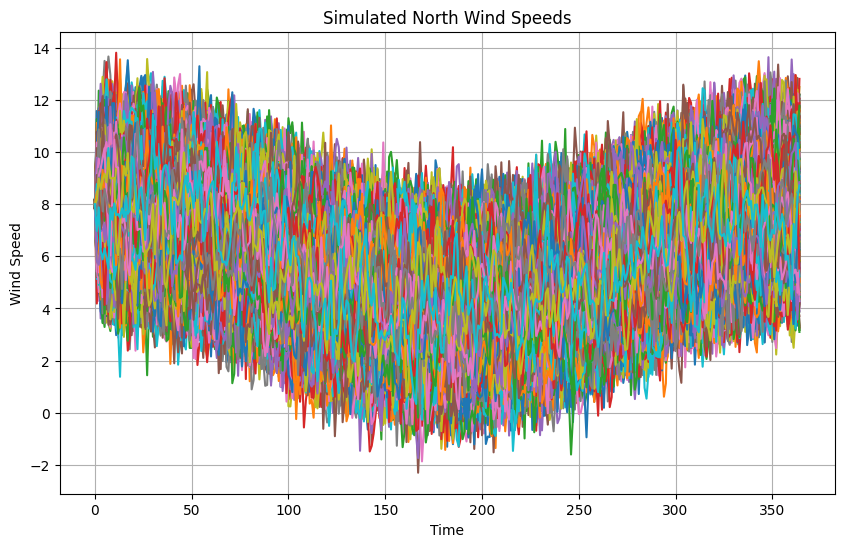

In [28]:
plt.figure(figsize=(10, 6))
for i in range(M):  # Para cada una de las 30 simulaciones
    plt.plot(North_Wind[i])
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Simulated North Wind Speeds')
plt.grid(True)
plt.show()

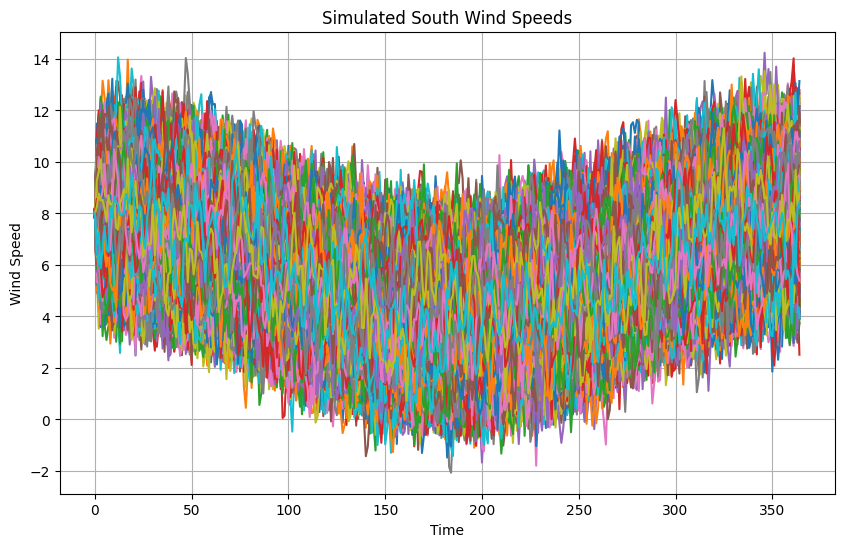

In [29]:
plt.figure(figsize=(10, 6))
for i in range(M): 
    plt.plot(South_Wind[i])
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Simulated South Wind Speeds')
plt.grid(True)
plt.show()

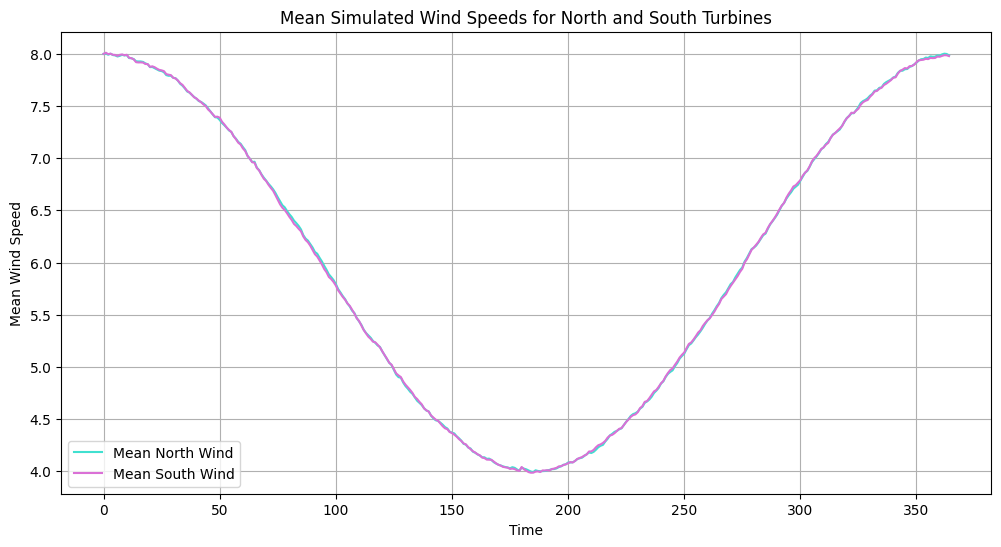

In [30]:
# Calcular la media a lo largo de las simulaciones para el Norte y el Sur
mean_Wind_North = np.mean(North_Wind, axis=0)
mean_Wind_South = np.mean(South_Wind, axis=0)

plt.figure(figsize=(12, 6))

# Graficar la media del viento del Norte
plt.plot(mean_Wind_North, color=c[0], label='Mean North Wind')

# Graficar la media del viento del Sur
plt.plot(mean_Wind_South, color=c[1], label='Mean South Wind')

plt.xlabel('Time')
plt.ylabel('Mean Wind Speed')
plt.title('Mean Simulated Wind Speeds for North and South Turbines')
plt.grid(True)
plt.legend()
plt.show()

### Explicación:
- El término $- \beta D_i \Delta$ representa la tendencia de la diferencia de viento a disminuir con el tiempo.
- El término $\gamma \sqrt{\Delta} W_i$ añade la variabilidad estocástica.

**Comparación visual y estadística descriptiva**

Datos Históricos: Media = 6.103829837195787 , Desviación Estándar = 1.8308179175700816
Simulación: Media = 5.999867978366676 , Desviación Estándar = 1.9110032979410514


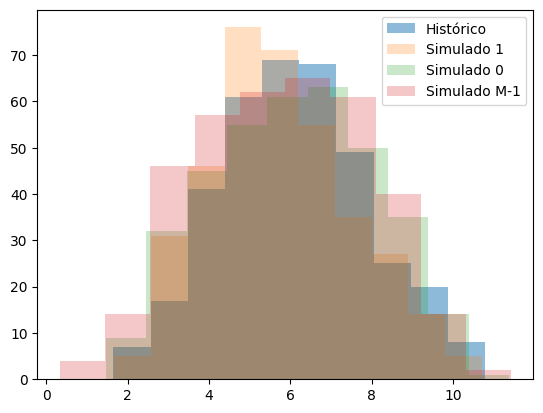

In [31]:
# Comparación de medias y desviaciones estándar
print("Datos Históricos: Media =", wind["regional wind"].iloc[:365].mean(), ", Desviación Estándar =", wind["regional wind"].iloc[:365].std())
print("Simulación: Media =", North_Wind.mean(), ", Desviación Estándar =", North_Wind.std())

# Comparación visual de histogramas
plt.hist(wind["regional wind"].iloc[:365], bins=10, alpha=0.5, label='Histórico')
plt.hist(North_Wind[1], bins=10, alpha=0.25, label='Simulado 1')
plt.hist(North_Wind[0], bins=10, alpha=0.25, label='Simulado 0')
plt.hist(North_Wind[M - 1], bins=10, alpha=0.25, label='Simulado M-1')
plt.legend()
plt.show()

### Comparación con Datos Históricos

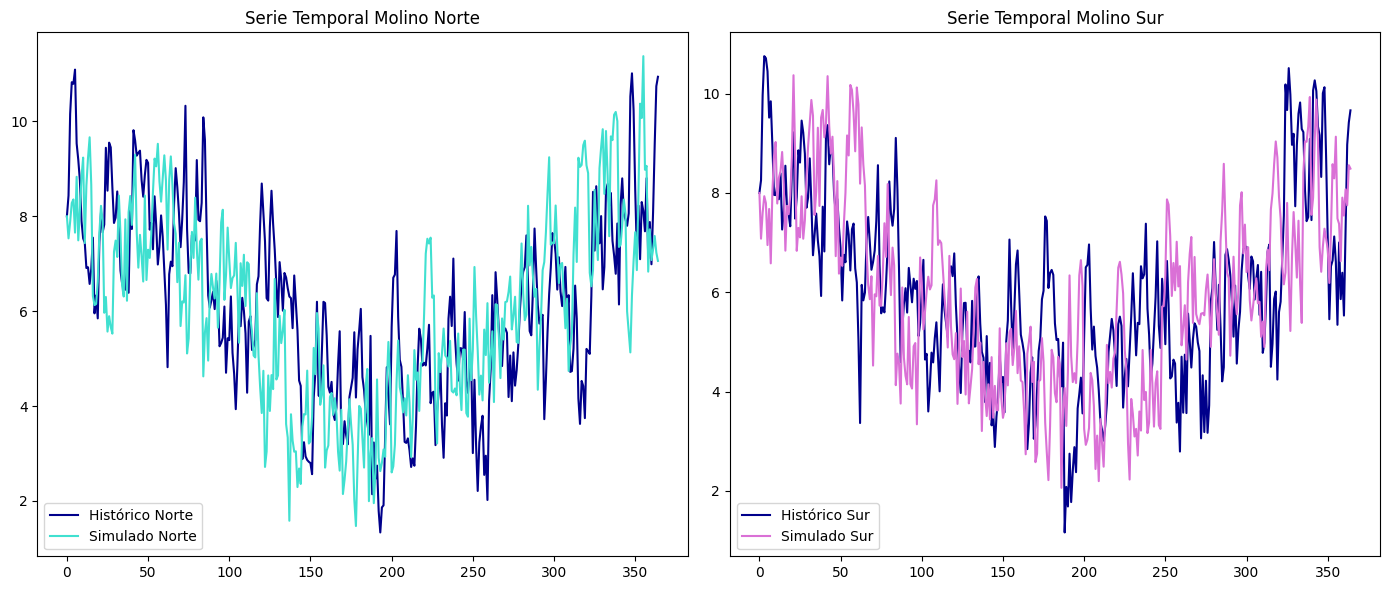

In [32]:
# Suponiendo que tienes datos históricos para ambos molinos:
# Extraer los primeros 365 valores históricos para comparación

plt.figure(figsize=(14, 6))

# Graficar series temporales
plt.subplot(1,2,1)
plt.plot(north_turbine_subset, label='Histórico Norte', color = 'darkblue')
plt.plot(North_Wind[0], label='Simulado Norte', color =c[0])
plt.title('Serie Temporal Molino Norte')
plt.legend()

plt.subplot(1,2,2)
plt.plot(south_turbine_subset, label='Histórico Sur', color = 'darkblue')
plt.plot(South_Wind[0], label='Simulado Sur', color = c[1])
plt.title('Serie Temporal Molino Sur')
plt.legend()

plt.tight_layout()
plt.show()


Comparación de la media y el desvío estándar:

In [33]:
# Media

print("Promedio de Histórico Norte: ", north_turbine_subset.mean().values[0])
print("Promedio de Simulado Norte", np.mean(North_Wind))


print("Promedio de Histórico Sur: ", south_turbine_subset.mean().values[0])
print("Promedio de Simulado Sur: ", np.mean(South_Wind))

Promedio de Histórico Norte:  6.138121361141543
Promedio de Simulado Norte 5.999867978366676
Promedio de Histórico Sur:  6.069538313250029
Promedio de Simulado Sur:  5.998315441573818


In [34]:
# Desviación estándar

print("Desviación estándar de Histórico Norte: ", north_turbine_subset.std().values[0])
print("Desviación estándar de Simulado Norte", np.std(North_Wind))


print("Desviación estándar de Histórico Sur: ", south_turbine_subset.std().values[0])
print("Desviación estándar de Simulado Sur: ", np.std(South_Wind))

Desviación estándar de Histórico Norte:  1.974926048599719
Desviación estándar de Simulado Norte 1.9110032979410514
Desviación estándar de Histórico Sur:  1.8369129168939304
Desviación estándar de Simulado Sur:  1.9089029795375707


### Pruebas Estadísticas para evaluar la similitud en términos de distribución

* Kolmogorov-Smirnov (KS) Test: Compara las distribuciones acumuladas de los datos históricos y simulados.

In [35]:
from scipy.stats import ks_2samp

# KS Test
ks_norte = ks_2samp(North_Wind.flatten(), north_turbine_subset.values.flatten())
ks_sur = ks_2samp(South_Wind.flatten(), south_turbine_subset.values.flatten())


print("KS Test Molino Norte:", ks_norte)
print("KS Test Molino Sur:", ks_sur)

KS Test Molino Norte: KstestResult(statistic=np.float64(0.04193041095890415), pvalue=np.float64(0.5285444022328785), statistic_location=np.float64(7.430577012970287), statistic_sign=np.int8(1))
KS Test Molino Sur: KstestResult(statistic=np.float64(0.059740000000000015), pvalue=np.float64(0.1418741178959686), statistic_location=np.float64(4.560801833703016), statistic_sign=np.int8(1))


### Resultados del Test de Kolmogorov-Smirnov (KS Test)

Los resultados del test KS sugieren que las distribuciones de los datos de viento simulados para ambos molinos (Norte y Sur) y sus respectivos subconjuntos de valores historicos de turbinas no son significativamente diferentes.

- **Molino Norte**: La simulación (North_Wind) muestra una distribución que es muy similar a los datos históricos (north_turbine_subset), con una diferencia máxima del 4.2% en las distribuciones acumuladas y un valor p de 0.5258, lo que indica que esta diferencia no es estadísticamente significativa, es decir, el modelo reproduce bien los datos históricos.
- **Molino Sur**: La mayor diferencia es del 5.9%, con un valor p de 0.147, lo que también sugiere que la diferencia no es estadísticamente significativa.
- **Conclusión**: Ambas simulaciones parecen ser representaciones bastante precisas de los datos históricos, ya que no hay diferencias estadísticamente significativas entre las distribuciones simuladas y las reales. Esto es positivo, ya que indica que el modelo de simulación utilizado está capturando de manera efectiva las características claves del comportamiento histórico del viento en ambos molinos.

## **Ejercicio 3: Simulación de Operaciones de los Molinos** <a name="Ejercicio-3"></a>
- **Simulación de las Operaciones de los Molinos:**
  - Simular la evolución diaria del viento en cada molino, incluyendo la simulación de fallas, decisiones de apagado/encendido, y acumulación de cashflows.

  

In [36]:

def sim_van(turbina, umbral, T, m, costo_apagado, costo_falla, ingreso_diario, costo_encendido):
    np.random.seed(3) #seed para que siempre sean los mismos random en el mismo orden (y no cambie la VAN)

    ingresos_totales = np.zeros((m, T))
    costos_totales = np.zeros((m, T))
    activo = np.ones((m, T), dtype=bool)  # Estado del molino (activo = True, apagado = False)
    fallos = np.zeros((m, T), dtype=bool)

    for i in range(m):
        for t in range(T):
            if t > 0:
                prob_falla = 0.25 * (turbina[i, t-1] ** 2) * delta
                if activo[i, t-1] and not fallos[i, t-1]:  
                    if np.random.random() < prob_falla:
                        fallos[i, t] = True
                        activo[i, t] = False 
                        costos_totales[i, t] += costo_falla
                        continue
                fallos[i, t] = False 
                if turbina[i, t] > umbral:
                    activo[i, t] = False 
                    if activo[i, t-1]:
                        costos_totales[i, t] += costo_apagado
                elif turbina[i, t] <= umbral:
                    activo[i, t] = True  
                    if not activo[i, t-1]:
                        costos_totales[i, t] += costo_encendido

            # Calculate daily income
            if activo[i, t]:
                ingresos_totales[i, t] = ingreso_diario * turbina[i, t]
   
    return ingresos_totales, costos_totales, activo, fallos

In [37]:
# Calcular flujo de caja y VAN
def calcular_VAN(ingresos, costos, T, tasa_interes):
    flujos_de_caja = ingresos - costos
    descuentos = np.exp(-tasa_interes * np.arange(T) / 365)
    flujos_de_caja_desc = flujos_de_caja * descuentos

    VAN = np.mean(np.sum(flujos_de_caja_desc, axis=1))
    return VAN


## **Ejercicio 4: Análisis de la Evolución del Estado de los Molinos** <a name="Ejercicio-4"></a>
- **Evolución del Estado de los Molinos:**
  - Graficar la evolución del estado de cada molino (activo/inactivo, roturas) a lo largo de un año, utilizando un camino típico del viento simulado.
  - Analizar si los resultados tienen sentido desde el punto de vista operativo.


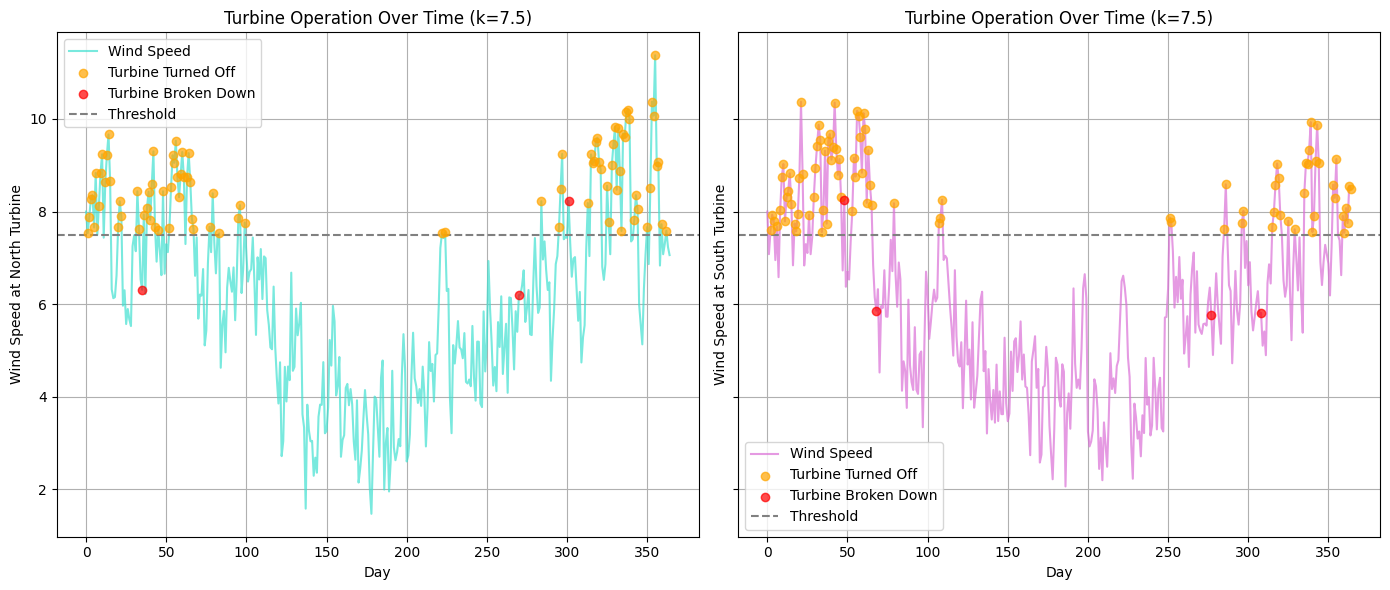

In [38]:
i = 0
T = 365

TASA_INTERES = 0.05
COSTO_APAGADO = 1000
COSTO_FALLA = 200000
INGRESO_DIARIO = 1000
COSTO_ENCENDIDO = 0
UMBRAL = 7.5



fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
np.random.seed(3) #seed para replicabilidad

for i, (turbina, label) in enumerate(zip([North_Wind, South_Wind], ['North Turbine', 'South Turbine'])):
    #m = np.random.randint(0, len(turbina))  
    ingresos_totales, costos_totales, activo, fallos = sim_van(turbina, UMBRAL, T, 1, COSTO_APAGADO, COSTO_FALLA, INGRESO_DIARIO, COSTO_ENCENDIDO) #elegimos el k al azar (aunque con algo de información de los puntos futuros)
    
    path_wind = turbina[0]
    path_activo = activo[0]
    path_fallos = fallos[0]

 
    axs[i].plot(path_wind, label='Wind Speed', color=c[i], alpha=0.7)
    
    
    turn_off_indices = np.where((path_activo == False) & (path_fallos == False))[0]
    
    axs[i].scatter(turn_off_indices, path_wind[turn_off_indices], color='orange', label='Turbine Turned Off', zorder=3, alpha=0.7)
    
    breakdown_indices = np.where(path_fallos == True)[0]
    axs[i].scatter(breakdown_indices, path_wind[breakdown_indices], color='red', label='Turbine Broken Down', zorder=5, alpha=0.7)

    axs[i].axhline(y=7.5, color='grey', linestyle='--', label='Threshold')

    axs[i].set_xlabel('Day')
    axs[i].set_ylabel(f'Wind Speed at {label}')
    axs[i].set_title(f'Turbine Operation Over Time (k={UMBRAL})')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


Observamos que aunque la probabilidad de una rotura aumenta con la velocidad del viento, hay algunas que suceden bastante por debajo del umbral. También se observa que a veces cuando la velocidad sobrepasa el umbral definido, a veces el molino se rompe antes de que tengamos la oportunidad de apagarlo. Esto tiene sentido por como definimos nuestro código, ya que el chequeo sobre la probabilidad de rotura se realiza antes que el chequeo sobre el umbral. Pensandolo en la realidad, este enfoque también tiene su lógica: si la velocidad aumenta temprano en el día o "de golpe" sobrepasa el umbral (de un día al otro) es posible que no lleguemos a revisar la velocidad y apagarlo antes de que se rompa.

## **Ejercicio 5: Cálculo del VAN Esperado** <a name="Ejercicio-5"></a>
- **VAN como Función del Umbral de Operación:**
  - A partir de un número grande de simulaciones, calcular el Valor Actual Neto (VAN) esperado como función del umbral de apagado/encendido.


In [39]:
def umbrales_prueba(turbina_norte, turbina_sur):
    umbrales = np.linspace(2, 12, 21)
    results = []
    errors_norte = []
    errors_sur = []

    ## nro de dias y cantidad de simulaciones definidos arriba (T,M)


    for k in umbrales:
        ingresos_norte, costos_norte, _, _= sim_van(turbina_norte, k, T, M, COSTO_APAGADO, COSTO_FALLA, INGRESO_DIARIO, COSTO_ENCENDIDO)
        ingresos_sur, costos_sur, _, _= sim_van(turbina_sur, k, T, M, COSTO_APAGADO, COSTO_FALLA, INGRESO_DIARIO, COSTO_ENCENDIDO)

        VAN_N = calcular_VAN(ingresos_norte, costos_norte, T, TASA_INTERES)
        VAN_S = calcular_VAN(ingresos_sur, costos_sur, T, TASA_INTERES)

        sem_norte = np.std(np.sum((ingresos_norte - costos_norte) * np.exp(-TASA_INTERES * np.arange(T) / 365), axis=1)) / np.sqrt(M)
        sem_sur = np.std(np.sum((ingresos_sur - costos_sur) * np.exp(-TASA_INTERES * np.arange(T) / 365), axis=1)) / np.sqrt(M)
        
        # Guardamos los resultados y los errores

        results.append({
            'k': k,
            'VAN Norte': VAN_N,
            'VAN Sur': VAN_S
        })

        errors_norte.append(sem_norte)
        errors_sur.append(sem_sur)

    df_results = pd.DataFrame(results)
    
    return df_results, errors_norte, errors_sur


In [40]:
def plot_both_VAN(res):
    #vemos como cambia la VAN segun el valor del umbral
    plt.figure(figsize=(10, 6))

    plt.plot(res['k'], res['VAN Norte']/1000, marker='o', color=c[0], label='VAN Norte')
    plt.plot(res['k'], res['VAN Sur']/1000, marker='o', color=c[1], label='VAN Sur')

    plt.xlabel('Umbral (k)')
    plt.ylabel('Valor Actual Neto (VAN) en miles de dolares')
    plt.title('Valor Actual Neto (VAN) vs. Umbral (k)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
#errorplot
def plot_van_error(res, errors_n, errors_s):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)

    titles = ['VAN Norte vs. Umbral (k)', 'VAN Sur vs. Umbral (k)']
    y_data = [res['VAN Norte'], res['VAN Sur']]
    errors = [np.array(errors_n), np.array(errors_s)]

    for i, (ax, title, y, err) in enumerate(zip(axes, titles, y_data, errors)):
        ax.errorbar(res['k'], y/1000, yerr=err/1000, marker='o', color=c[i], label=y)
        ax.set_xlabel('Umbral (k)')
        ax.set_ylabel('VAN en miles de dólares, junto a los errores estándar')
        ax.set_title(title)
        ax.grid(True)

    plt.show()

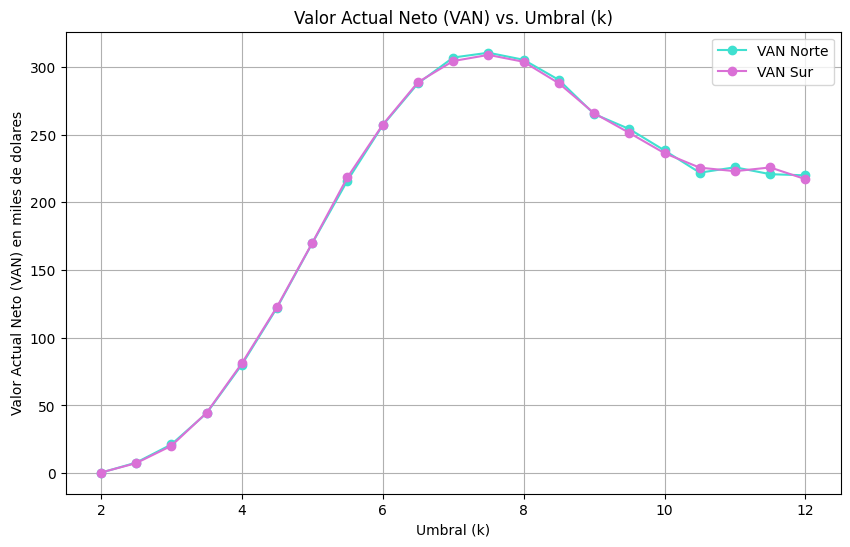

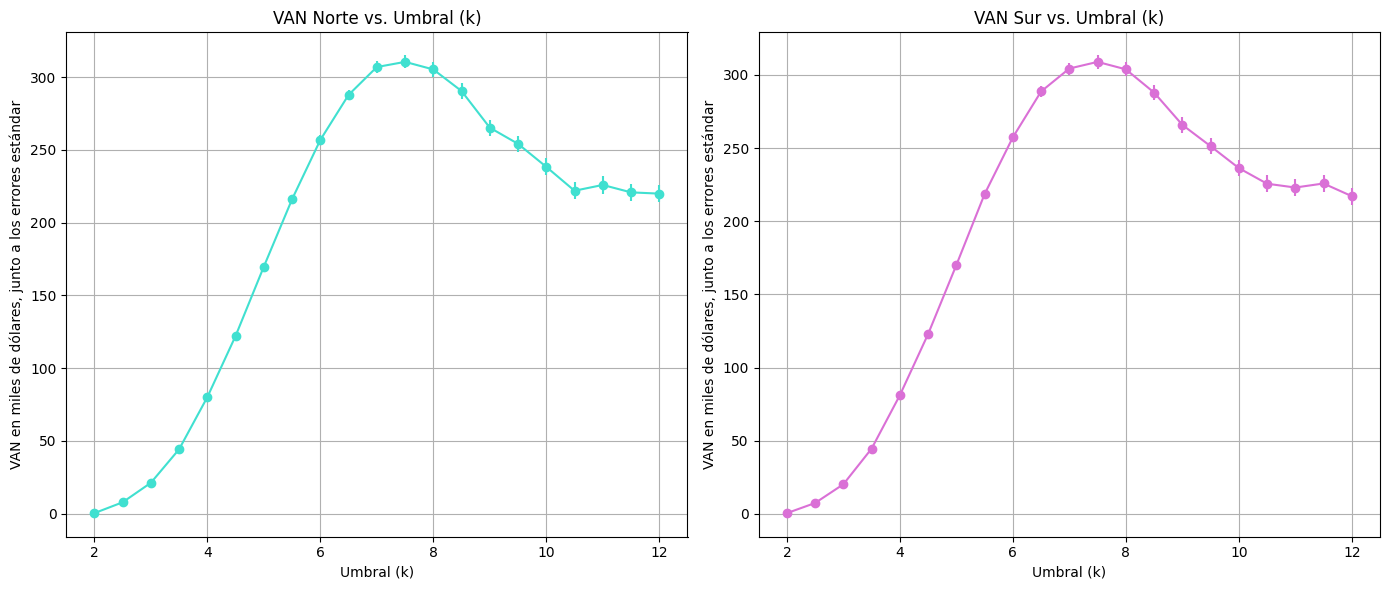

In [42]:
res, errores_norte, errores_sur = umbrales_prueba(North_Wind, South_Wind)
plot_both_VAN(res)
plot_van_error(res, errores_norte, errores_sur)

## **Ejercicio 6: Optimización del Umbral de Operación** <a name="Ejercicio-6"></a>
- **Umbral Óptimo:**
  - Determinar el valor óptimo del umbral de apagado y encendido que maximiza el VAN esperado durante un año.

In [43]:
max_N = res['VAN Norte'].max()
optimal_k_N = res[res['VAN Norte'] == max_N]['k'].values[0]

print(f"La VAN del molino norte se maximiza cuando k = {optimal_k_N:.2f}, con un VAN de {max_N:.2f} dólares.")

max_S = res['VAN Sur'].max()
optimal_k_S = res[res['VAN Sur'] == max_S]['k'].values[0]

print(f"La VAN del molino sur se maximiza cuando k = {optimal_k_S:.2f}, con un VAN de {max_S:.2f} dólares.")

La VAN del molino norte se maximiza cuando k = 7.50, con un VAN de 310523.13 dólares.
La VAN del molino sur se maximiza cuando k = 7.50, con un VAN de 308923.45 dólares.


## **Ejercicio 7: Comparación con la Operación Ingenua** <a name="Ejercicio-7"></a>
- **Comparación de Estrategias:**
  - Comparar la ganancia en VAN al utilizar la estrategia óptima versus una operación ingenua que nunca apaga los molinos.


In [44]:
#Calculo operación ingenua, nunca apago molino
#Sabiendo que el viento no supera los 100m/seg digo que ese es el umbral para simular nunca apagarlo
umbral_k = 100
#T = 365
ingresos_ingenuo_n, costos_ingenuo_n, activo_ingenuo_n, fallos_ingenuo_n = sim_van(North_Wind, umbral_k, T, M, COSTO_APAGADO, COSTO_FALLA, INGRESO_DIARIO, COSTO_ENCENDIDO)
ingresos_ingenuo_s, costos_ingenuo_s, activo_ingenuo_s, fallos_ingenuo_s= sim_van(South_Wind, umbral_k, T, M, COSTO_APAGADO, COSTO_FALLA, INGRESO_DIARIO, COSTO_ENCENDIDO)

VAN_ingenuo_n = calcular_VAN(ingresos_ingenuo_n, costos_ingenuo_n, T, TASA_INTERES)
VAN_ingenuo_s = calcular_VAN(ingresos_ingenuo_s, costos_ingenuo_s, T, TASA_INTERES)

#Simulación con óptimo

ingresos_n, costos_n, activo_n, fallos_n = sim_van(North_Wind, optimal_k_N, T, M, COSTO_APAGADO, COSTO_FALLA, INGRESO_DIARIO, COSTO_ENCENDIDO)
ingresos_s, costos_s, activo_s, fallos_s= sim_van(South_Wind, optimal_k_S, T, M, COSTO_APAGADO, COSTO_FALLA, INGRESO_DIARIO, COSTO_ENCENDIDO)

VAN_op_n = calcular_VAN(ingresos_n, costos_n, T, TASA_INTERES)
VAN_op_s = calcular_VAN(ingresos_s, costos_s, T, TASA_INTERES)

print(f"\nComparación de VAN entre simulaciones:")
print(f"{'Molino':<15} {'Método':<15} {'VAN ($)':>15}")
print(f"{'-'*45}")

print(f"{'Norte':<15} {'Óptimo':<15} {VAN_op_n:>15,.2f}")
print(f"{'Norte':<15} {'Ingenuo':<15} {VAN_ingenuo_n:>15,.2f}")
print(f"{'Sur':<15} {'Óptimo':<15} {VAN_op_s:>15,.2f}")
print(f"{'Sur':<15} {'Ingenuo':<15} {VAN_ingenuo_s:>15,.2f}")



Comparación de VAN entre simulaciones:
Molino          Método                  VAN ($)
---------------------------------------------
Norte           Óptimo               310,523.13
Norte           Ingenuo              221,229.74
Sur             Óptimo               308,923.45
Sur             Ingenuo              227,320.96


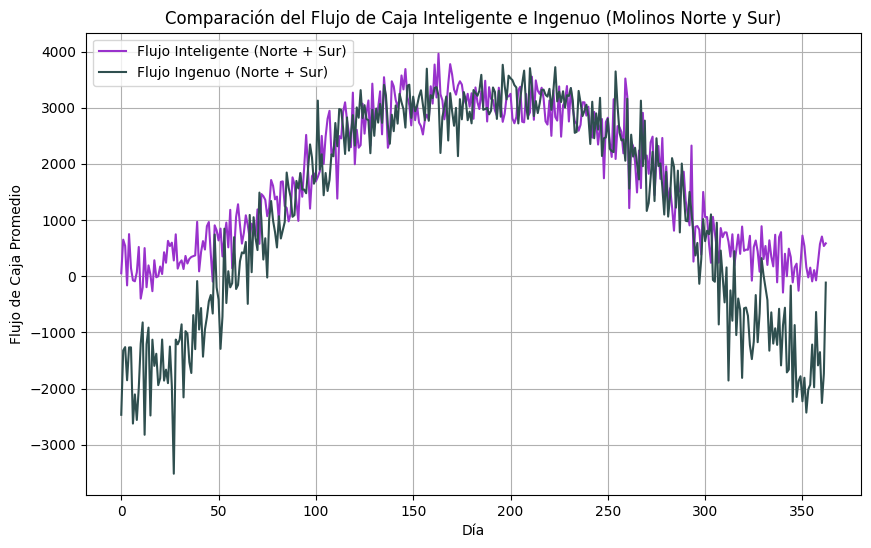

In [45]:
plt.figure(figsize=(10, 6))

plt.plot(np.mean((ingresos_n + ingresos_s) - (costos_n + costos_s), axis=0)[2:], label='Flujo Inteligente (Norte + Sur)', color='darkorchid')

plt.plot(np.mean((ingresos_ingenuo_n + ingresos_ingenuo_s) - (costos_ingenuo_n + costos_ingenuo_s), axis=0)[2:], label='Flujo Ingenuo (Norte + Sur)', color='darkslategrey')

plt.title('Comparación del Flujo de Caja Inteligente e Ingenuo (Molinos Norte y Sur)')
plt.xlabel('Día')
plt.ylabel('Flujo de Caja Promedio')

plt.legend()
plt.grid(True)

plt.show()


## **Ejercicio 8: Distribución de Ingresos de Agosto** <a name="Ejercicio-8"></a>
- **Distribución de Ingresos:**
  - Calcular y graficar la distribución del ingreso total durante el mes de agosto (sin descontar) bajo el umbral de operación óptimo.


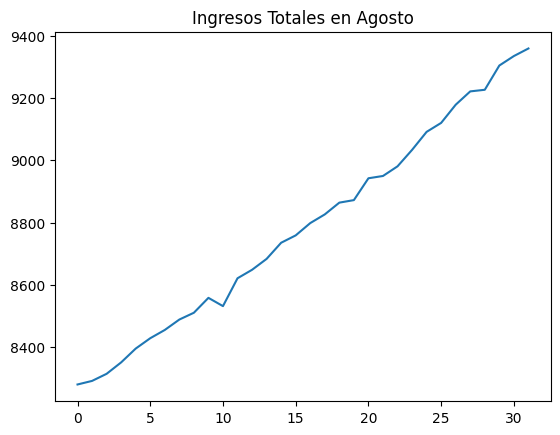

In [46]:
#Sumamos ambos ingresos y luego tomamos unicamente en los dias de agosto
ingresos_totales= ingresos_n + ingresos_s
start_day = 213
month_duration = 31
end_day = start_day + month_duration

ingresos_agosto = ingresos_totales[:, start_day : end_day+1]

plt.plot(np.mean(ingresos_agosto, axis = 0))
plt.title('Ingresos Totales en Agosto')
plt.show()

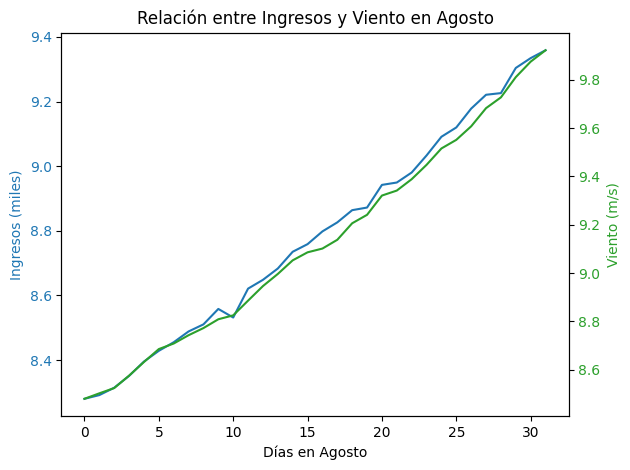

In [47]:
#Relación precio - velocidad del viento
viento_agosto = North_Wind + South_Wind
viento_total = viento_agosto[:, start_day : end_day+1] 

fig, ax1 = plt.subplots()

ax1.set_xlabel('Días en Agosto')
ax1.set_ylabel('Ingresos (miles)', color='tab:blue')
ax1.plot(np.mean(ingresos_agosto/1000, axis=0), color='tab:blue', label='Ingresos')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Viento (m/s)', color='tab:green')  
ax2.plot(np.mean(viento_total, axis=0), color='tab:green', label='Viento')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Relación entre Ingresos y Viento en Agosto')
fig.tight_layout()  
plt.show()


## **Ejercicio 9: Análisis de Roturas** <a name="Ejercicio-9"></a>
- **Número Medio de Roturas:**
  - Calcular el número medio de roturas por año que sufre cada molino bajo la estrategia óptima y compararlo con el caso en que nunca se apagan.



Comparación de roturas entre simulaciones:
Molino          Método               (#) Rotura
---------------------------------------------
Norte           Óptimo                     5.51
Norte           Ingenuo                    9.49
Sur             Óptimo                     5.52
Sur             Ingenuo                    9.45


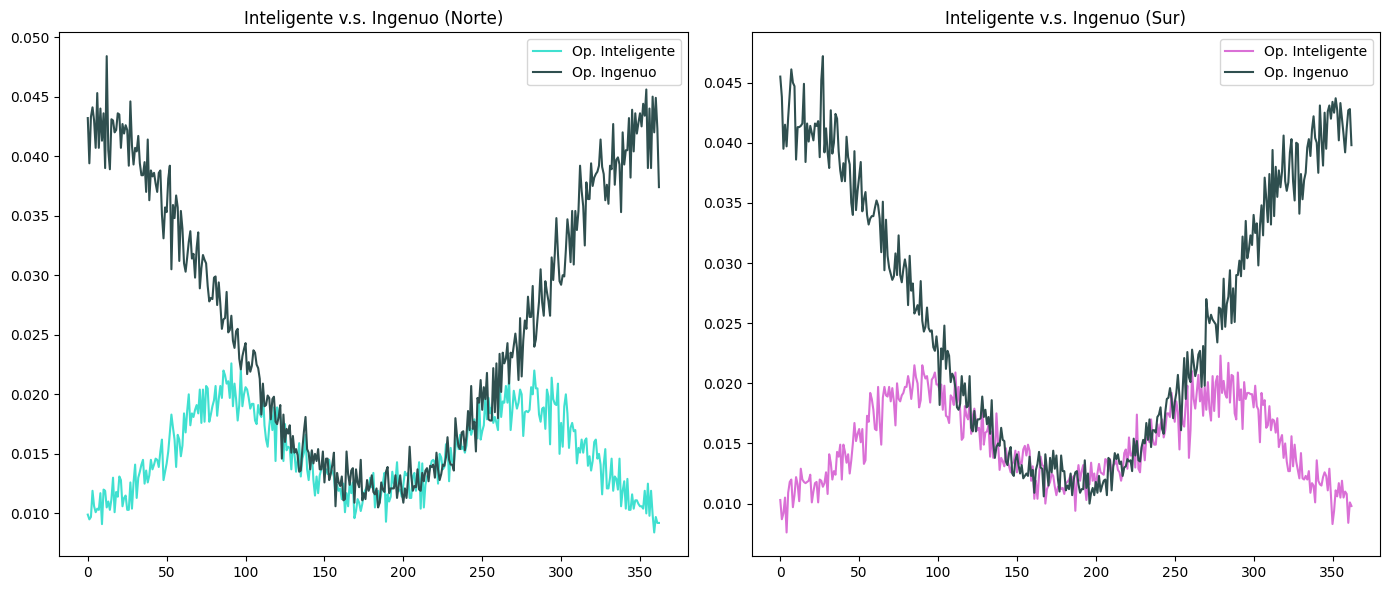

In [48]:
#Utilizamos el cálculo hecho previamente para calcular los fallos
print(f"\nComparación de roturas entre simulaciones:")
print(f"{'Molino':<15} {'Método':<15} {'(#) Rotura':>15}")
print(f"{'-'*45}")

print(f"{'Norte':<15} {'Óptimo':<15} {np.mean(np.sum(fallos_n, axis = 1)):>15,.2f}")
print(f"{'Norte':<15} {'Ingenuo':<15} {np.mean(np.sum(fallos_ingenuo_n, axis = 1)):>15,.2f}")
print(f"{'Sur':<15} {'Óptimo':<15} {np.mean(np.sum(fallos_s, axis = 1)):>15,.2f}")
print(f"{'Sur':<15} {'Ingenuo':<15} {np.mean(np.sum(fallos_ingenuo_s, axis = 1)):>15,.2f}")
plt.figure(figsize=(14, 6))

# Graficar series temporales
plt.subplot(1,2,1)
plt.plot(np.mean(fallos_n, axis = 0)[2:], label='Op. Inteligente', color =c[0])
plt.plot(np.mean(fallos_ingenuo_n, axis = 0)[2:], label='Op. Ingenuo', color = 'darkslategrey')
plt.title('Inteligente v.s. Ingenuo (Norte)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.mean(fallos_s, axis = 0)[2:], label='Op. Inteligente', color = c[1])
plt.plot(np.mean(fallos_ingenuo_s, axis = 0)[2:], label='Op. Ingenuo', color = 'darkslategrey')
plt.title('Inteligente v.s. Ingenuo (Sur)')
plt.legend()

plt.tight_layout()
plt.show()

## **Ejercicio 10: Días Inactivos** <a name="Ejercicio-10"></a>
- **Días Inactivos:**
  - Calcular el número medio de días por año en que cada molino está inactivo, ya sea por apagado voluntario o rotura.



In [49]:
print(f"\nComparación de inactividad entre simulaciones:")
print(f"{'Molino':<15} {'Método':<15} {'(#) Inactividad':>15}")
print(f"{'-'*45}")

print(f"{'Norte':<15} {'Óptimo':<15} {365 - np.sum(np.mean(activo_n, axis = 0)):>15,.2f}")
print(f"{'Norte':<15} {'Ingenuo':<15} {365 - np.sum(np.mean(activo_ingenuo_n, axis = 0)):>15,.2f}")
print(f"{'Sur':<15} {'Óptimo':<15} {365 - np.sum(np.mean(activo_s, axis = 0)):>15,.2f}")
print(f"{'Sur':<15} {'Ingenuo':<15} {365 - np.sum(np.mean(activo_ingenuo_s, axis = 0)):>15,.2f}")
plt.figure(figsize=(14, 6))


Comparación de inactividad entre simulaciones:
Molino          Método          (#) Inactividad
---------------------------------------------
Norte           Óptimo                    89.42
Norte           Ingenuo                    9.49
Sur             Óptimo                    89.32
Sur             Ingenuo                    9.45


<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

## **Ejercicio 11: Probabilidades de Inactividad** <a name="Ejercicio-11"></a>
- **Probabilidades de Inactividad:**
  - Calcular la probabilidad de que ambos molinos estén inactivos el 9 de julio y en cualquier día del año.

In [50]:
#Para 9 de julio, buscamos en todos los caminos, la # de veces que ambos estuvieron inactivos
inactivo_total_9_julio = 0
for camino in range(M):
    if activo_n[camino,190] == False and activo_s[camino, 190] == False:
        inactivo_total_9_julio += 1

prob_9_julio = inactivo_total_9_julio/M
print(prob_9_julio)

inactivos_totales = 0
for camino in range(M):
    for dia in range(T):
        if activo_n[camino,dia] == False and activo_s[camino, dia] == False:
            inactivos_totales += 1

prob_general = inactivos_totales/(M*T)
print(prob_general)


0.0007
0.16727013698630136


## **Ejercicio 12: Correlación de Ingresos** <a name="Ejercicio-12"></a>
- **Correlación entre Molinos:**
  - Calcular la correlación entre los ingresos totales mensuales de mayo de los dos molinos.


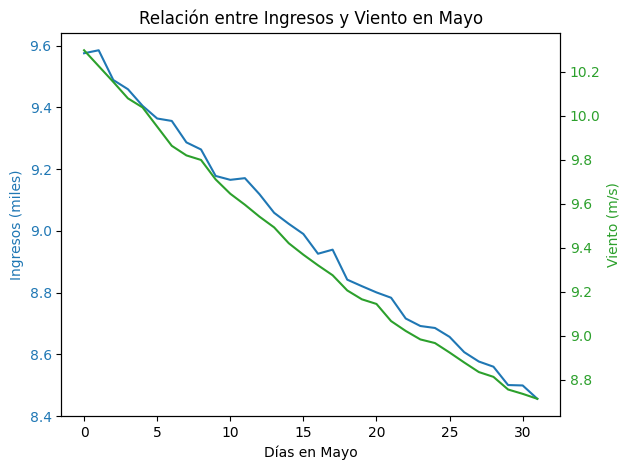

Correlación entre los ingresos totales mensuales de mayo de los dos molinos: 0.33519240580121423


In [51]:
# Ingresos de mayo (días 121 al 151)
ingresos_mayo_n= ingresos_n[:, 120:152]
ingresos_mayo_s = ingresos_s[:, 120:152]

ingresos_mayo = ingresos_mayo_s + ingresos_mayo_n

#Relación precio - velocidad del viento
viento_mayo = North_Wind + South_Wind
viento_total = viento_mayo[:, 120 : 152] 

fig, ax1 = plt.subplots()

ax1.set_xlabel('Días en Mayo')
ax1.set_ylabel('Ingresos (miles)', color='tab:blue')
ax1.plot(np.mean(ingresos_mayo/1000, axis=0), color='tab:blue', label='Ingresos')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Viento (m/s)', color='tab:green')  
ax2.plot(np.mean(viento_total, axis=0), color='tab:green', label='Viento')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Relación entre Ingresos y Viento en Mayo')
fig.tight_layout()  
plt.show()

i_norte = []
i_sur = []

for camino in range(M):
    i_norte.append(np.sum(ingresos_mayo_n[camino, :]))
    i_sur.append(np.sum(ingresos_mayo_s[camino, :]))

# Calcular la correlación entre los ingresos de mayo de ambos molinos
correlacion_mayo = np.corrcoef(i_norte, i_sur)[0, 1]
print(f"Correlación entre los ingresos totales mensuales de mayo de los dos molinos: {correlacion_mayo}")

## **Ejercicio 13: Sensibilidad al Costo de Reparación** <a name="Ejercicio-13"></a>
- **Análisis de Sensibilidad al Costo de Reparación:**
  - Analizar cómo afecta al VAN y al umbral óptimo un aumento en el costo de reparación a 250 mil dólares.


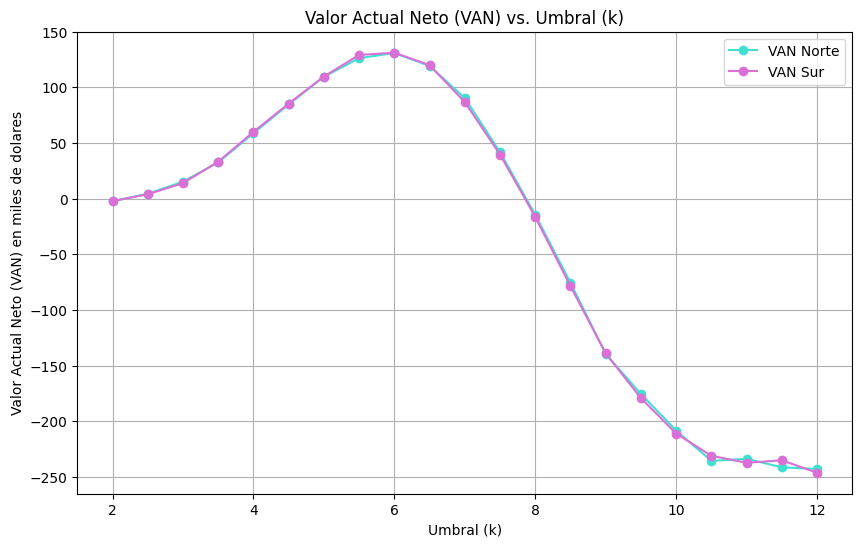

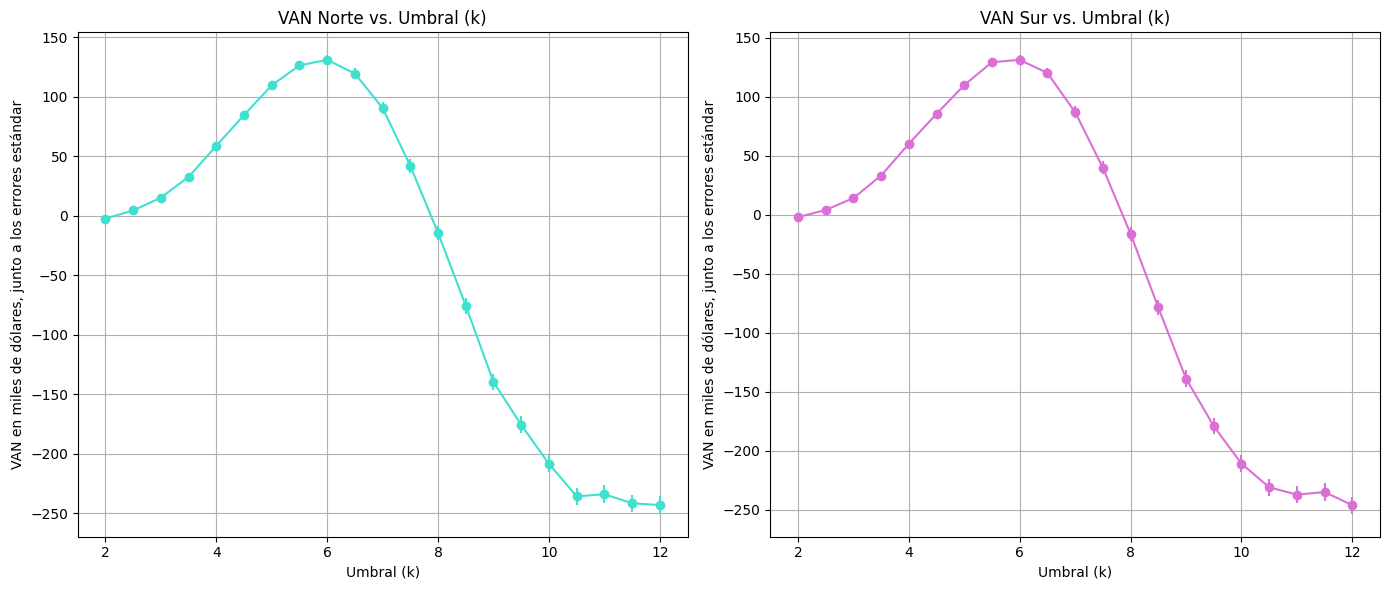

In [52]:
COSTO_FALLA = 250000
res_nuevo, errores_n_nuevo, errores_s_nuevo = umbrales_prueba(North_Wind, South_Wind)

plot_both_VAN(res_nuevo)
plot_van_error(res_nuevo, errores_n_nuevo, errores_s_nuevo)

In [53]:
max_N_nuevo = res_nuevo['VAN Norte'].max()
optimal_k_N_nuevo = res_nuevo[res_nuevo['VAN Norte'] == max_N_nuevo]['k'].values[0]

print(f"La VAN del molino norte se maximiza cuando k = {optimal_k_N_nuevo:.2f}, con un VAN de {max_N_nuevo:.2f} dólares.")

max_S_nuevo = res_nuevo['VAN Sur'].max()
optimal_k_S_nuevo = res_nuevo[res_nuevo['VAN Sur'] == max_S_nuevo]['k'].values[0]

print(f"La VAN del molino sur se maximiza cuando k = {optimal_k_S_nuevo:.2f}, con un VAN de {max_S_nuevo:.2f} dólares.")

La VAN del molino norte se maximiza cuando k = 6.00, con un VAN de 130892.00 dólares.
La VAN del molino sur se maximiza cuando k = 6.00, con un VAN de 131128.11 dólares.


## **Ejercicio 14: Sensibilidad a la Media Estacional** <a name="Ejercicio-14"></a>
- **Análisis de Sensibilidad a la Media Estacional:**
  - Explorar cómo afectan los cambios en la media estacional del viento al VAN y a las decisiones operativas.


In [55]:
COSTO_FALLA = 200000
results_14 = []
errors_norte_14 = []
errors_sur_14 = []
bases = np.linspace(3, 9, 8)

## nro de dias y cantidad de simulaciones definidos arriba (T,M)

#Armo función a parte para calcular theta
def theta(b):
    t = b + (2 * np.cos((2 * np.pi * wind["dia"])/365))
    return t

for base in bases:
    S_0 = base + 2
    #Calculo theta
    tita = theta(base)
    k = base * 1.25

    #Vuelvo a simular el viento de ambos molinos
    molino_norte, molino_sur = simulate_wind_turbines(S_0, kappa_est, tita, delta, sigma_est, D_0, gamma_est, beta_est, M, T)

    #Simulamos la VAN para cada molino
    ingresos_norte_14, costos_norte_14, _, _= sim_van(molino_norte, k, T, M, COSTO_APAGADO, COSTO_FALLA, INGRESO_DIARIO, COSTO_ENCENDIDO)
    ingresos_sur_14, costos_sur_14, _, _= sim_van(molino_sur, k, T, M, COSTO_APAGADO, COSTO_FALLA, INGRESO_DIARIO, COSTO_ENCENDIDO)

    VAN_N_14 = calcular_VAN(ingresos_norte_14, costos_norte_14, T, TASA_INTERES)
    VAN_S_14 = calcular_VAN(ingresos_sur_14, costos_sur_14, T, TASA_INTERES)

    sem_norte_14 = np.std(np.sum((ingresos_norte_14 - costos_norte_14) * np.exp(-TASA_INTERES * np.arange(T) / 365), axis=1)) / np.sqrt(M)
    sem_sur_14 = np.std(np.sum((ingresos_sur_14 - costos_sur_14) * np.exp(-TASA_INTERES * np.arange(T) / 365), axis=1)) / np.sqrt(M)
    
    # Guardamos los resultados y los errores

    results_14.append({
        'media estacional': base,
        'VAN Norte': VAN_N_14,
        'VAN Sur': VAN_S_14
    })

    errors_norte_14.append(sem_norte_14)
    errors_sur_14.append(sem_sur_14)

df_results_14 = pd.DataFrame(results_14)

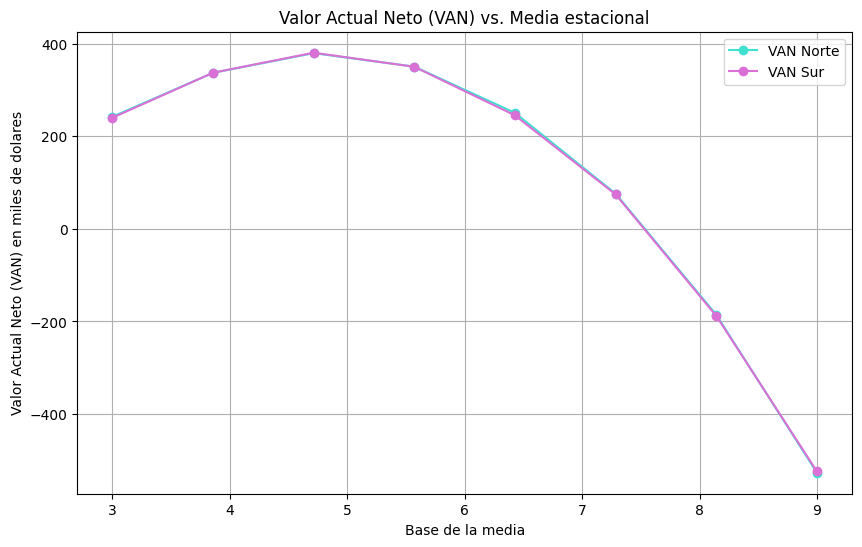

In [60]:
#vemos como cambia la VAN segun el valor del umbral
plt.figure(figsize=(10, 6))

plt.plot(df_results_14['media estacional'], df_results_14['VAN Norte']/1000, marker='o', color=c[0], label='VAN Norte')
plt.plot(df_results_14['media estacional'], df_results_14['VAN Sur']/1000, marker='o', color=c[1], label='VAN Sur')

plt.xlabel('Base de la media')
plt.ylabel('Valor Actual Neto (VAN) en miles de dolares')
plt.title('Valor Actual Neto (VAN) vs. Media estacional')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
max_N = df_results_14['VAN Norte'].max()
optimal_k_N = df_results_14[df_results_14['VAN Norte'] == max_N]['media estacional'].values[0]

print(f"La VAN del molino norte se maximiza cuando b = {optimal_k_N:.2f}, con un VAN de {max_N:.2f} dólares.")

max_S = df_results_14['VAN Sur'].max()
optimal_k_S = df_results_14[df_results_14['VAN Sur'] == max_S]['media estacional'].values[0]

print(f"La VAN del molino sur se maximiza cuando b = {optimal_k_S:.2f}, con un VAN de {max_S:.2f} dólares.")

La VAN del molino norte se maximiza cuando b = 4.71, con un VAN de 379589.38 dólares.
La VAN del molino sur se maximiza cuando b = 4.71, con un VAN de 380561.80 dólares.


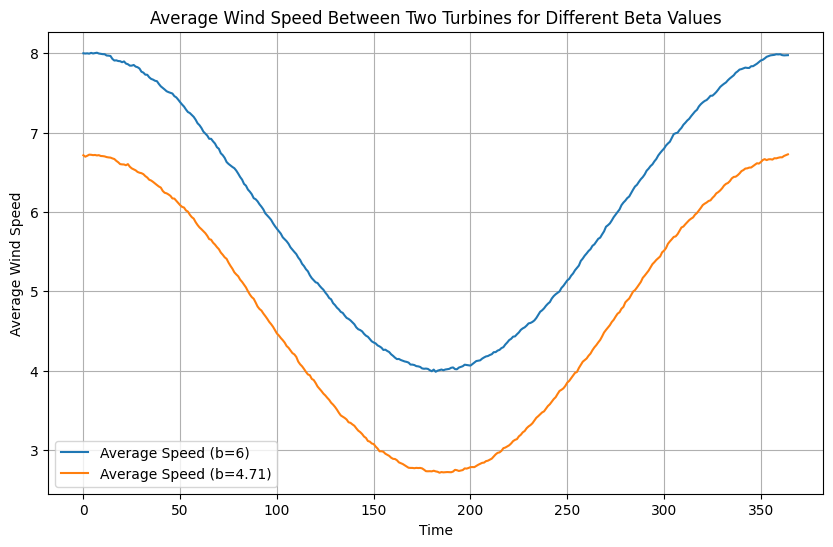

In [57]:
base_values = [6, optimal_k_S]

avg_speeds = []

for base in base_values:
    S_0 = base + 2
    tita = theta(base)
    molino_norte, molino_sur = simulate_wind_turbines(S_0, kappa_est, tita, delta, sigma_est, D_0, gamma_est, beta_est, M, T)
    
    # Calculate average wind speeds
    avg_wind_speed_norte = np.mean(molino_norte, axis=0)
    avg_wind_speed_sur = np.mean(molino_sur, axis=0)
    
    # Calculate the average wind speed between both turbines
    avg_speed_between_turbines = (avg_wind_speed_norte + avg_wind_speed_sur) / 2
    avg_speeds.append(avg_speed_between_turbines)

# Plotting
plt.figure(figsize=(10, 6))

# Plot average speeds for each beta value
for i, beta in enumerate(base_values):
    plt.plot(avg_speeds[i], label=f'Average Speed (b={round(beta,2)})')

plt.xlabel('Time')
plt.ylabel('Average Wind Speed')
plt.title('Average Wind Speed Between Two Turbines for Different Beta Values')
plt.legend()
plt.grid(True)
plt.show()
